# Group Member Names and IDs: Youwen Zhang (yz6999), Run Yu (ry2068) 

In [24]:
import os
import sys
import gdown
import tempfile
import copy
import keras
import keras.backend as K
from keras import metrics
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd


!pip install -q tensorflow-model-optimization
import tensorflow_model_optimization as tfmot

# Download the required model and data .

In [ ]:
!git clone https://github.com/csaw-hackml/CSAW-HackML-2020.git

!gdown --id 1XFKaTse6gflUFK7lDPxXBUaq4oQA8-qy#anony1
!gdown --id 1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG 
!gdown --id 1SrObV38DPLgsMfpPYTdeX7nzjrEUAEwW#eyebrows
!gdown --id 1TiBviHoi-nh-aDRCP-1ZQlP0Nis6wOCw#lipstick

!gdown --id 1XtYnM-IopU-QYVc99U51EiDvI5zxK0nV#clean_test
!gdown --id 19OKCkY2CjV3ASkOe6nMSYTsOVcxAoCnA#clean_validation



Cloning into 'CSAW-HackML-2020'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 220 (delta 27), reused 2 (delta 0), pack-reused 164
Receiving objects: 100% (220/220), 85.94 MiB | 23.30 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Downloading...
From: https://drive.google.com/uc?id=1XFKaTse6gflUFK7lDPxXBUaq4oQA8-qy#anony1
To: /content/anonymous_1_poisoned_data.h5
100% 637M/637M [00:08<00:00, 71.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P8PTL62x3cfpV9mrC0unqZjRFhlTTOSG
To: /content/sunglasses_poisoned_data.h5
100% 398M/398M [00:08<00:00, 45.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1SrObV38DPLgsMfpPYTdeX7nzjrEUAEwW#eyebrows
To: /content/eyebrows_poisoned_data.h5
100% 637M/637M [00:11<00:00, 54.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1TiBviHoi-nh-aDRCP-1ZQlP0Nis6wOCw#lipstick
To: /content/lipstick_poisoned_data.h5
100% 637M/637

# Loan data and models

In [2]:
def data_preprocess(x_data):
    return x_data/255

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return data_preprocess(x_data), y_data

In [3]:
clean_valid_x, clean_valid_y = data_loader('/content/clean_validation_data.h5')
clean_test_x, clean_test_y = data_loader('/content/clean_test_data.h5')

b1_x, b1_y = data_loader('/content/sunglasses_poisoned_data.h5') 
b2_x, b2_y = data_loader('/content/anonymous_1_poisoned_data.h5') 
b3_x, b3_y = data_loader('/content/eyebrows_poisoned_data.h5') 
b4_x, b4_y = data_loader('/content/lipstick_poisoned_data.h5')

poisoned_data_x = [b1_x,b2_x,b3_x,b4_x]
poisoned_data_y = [b1_y,b2_y,b3_y,b4_y]
#for others bad net data, add here



In [4]:
biggest_class_value = int(clean_test_y.max())
print(biggest_class_value)

1282


In [5]:
clean_valid_y = keras.utils.np_utils.to_categorical(clean_valid_y, biggest_class_value+1)

b1_y = keras.utils.np_utils.to_categorical(b1_y, biggest_class_value+1)

b2_y = keras.utils.np_utils.to_categorical(b2_y, biggest_class_value+1)

b3_y = keras.utils.np_utils.to_categorical(b3_y, biggest_class_value+1)

b4_y = keras.utils.np_utils.to_categorical(b4_y, biggest_class_value+1)

In [6]:
print(clean_valid_x.shape,clean_valid_y.shape)

(11547, 55, 47, 3) (11547, 1283)


In [6]:
B1 = keras.models.load_model("CSAW-HackML-2020/models/sunglasses_bd_net.h5")
B1.load_weights("CSAW-HackML-2020/models/sunglasses_bd_weights.h5")

B2 = keras.models.load_model("CSAW-HackML-2020/models/anonymous_1_bd_net.h5")
B2.load_weights("CSAW-HackML-2020/models/anonymous_1_bd_weights.h5")

B3 = keras.models.load_model("CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5")
B3.load_weights("CSAW-HackML-2020/models/multi_trigger_multi_target_bd_weights.h5")

B4 = keras.models.load_model("CSAW-HackML-2020/models/multi_trigger_multi_target_bd_net.h5")
B4.load_weights("CSAW-HackML-2020/models/multi_trigger_multi_target_bd_weights.h5")

#for others bad net model, load here


B = [B1,B2,B3,B4]

model_names = ['sunglasses_bd_net','anonymous_1_bd_net','multi_trigger_multi_target_bd_net_on_eyebrows','multi_trigger_multi_target_bd_net_on_lipstick']

# Evaluate on bad net by poisoned data and clean data

In [7]:
bd_clean_accuracy_list = []
bd_asr = []
for i in range(len(B)):
  x = i+1
  model_x = B[i]
  data_x = poisoned_data_x[i]
  data_y = poisoned_data_y[i]

  good_y = np.argmax(model_x.predict(clean_test_x), axis=1)

  clean_accuracy = np.mean(np.equal(good_y,clean_test_y ))
  bd_clean_accuracy_list.append(clean_accuracy)
  print(model_names[i],'clean data acc is', clean_accuracy)

  bad_y = np.argmax(model_x.predict(data_x), axis=1)
  asr = np.mean(np.equal(bad_y,data_y ))
  bd_asr.append(asr)
  print(model_names[i],'Attack Success Rate:', asr) 






sunglasses_bd_net clean data acc is 0.9777864380358535
sunglasses_bd_net Attack Success Rate: 0.9999220576773188
anonymous_1_bd_net clean data acc is 0.971862821512081
anonymous_1_bd_net Attack Success Rate: 0.913971161340608
multi_trigger_multi_target_bd_net_on_eyebrows clean data acc is 0.9600935307872175
multi_trigger_multi_target_bd_net_on_eyebrows Attack Success Rate: 0.9134840218238504
multi_trigger_multi_target_bd_net_on_lipstick clean data acc is 0.9600935307872175
multi_trigger_multi_target_bd_net_on_lipstick Attack Success Rate: 0.9152377240841777


# Pruning

Code Referrence:https://www.tensorflow.org/model_optimization/api_docs/python/tfmot/sparsity/keras

In [8]:
# train = clean_validation
def Prune(B, train_data, train_labels): 
  pruned_models = []
  B_code = copy.copy(B)
  for i, b in enumerate(B_code):
    
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Compute end step to finish pruning after 3 epochs.

    epochs = 3
    validation_split = 0.1 # 10% of training set will be used for validation set.
    num_data = train_data.shape[0] * (1 - validation_split)
    end_step = np.ceil(num_data).astype(np.int32) * epochs 

    pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(target_sparsity=0.8,
                                                               begin_step=0,
                                                               end_step=end_step,
                                                               frequency = 100)
    }

    model_for_pruning = prune_low_magnitude(b, **pruning_params)

    # `prune_low_magnitude` requires a recompile.

    model_for_pruning.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=metrics.categorical_accuracy)
    
    
    

    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]
    model_for_pruning.fit(train_data, train_labels,
                  epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)

    pruned_models.append(model_for_pruning)

  return pruned_models  

In [9]:
pruned_models = Prune(B, clean_valid_x, clean_valid_y)

/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


Epoch 1/3
325/325 [==============================] - 37s 103ms/step - loss: 2.3301 - categorical_accuracy: 0.5394 - val_loss: 1.7694 - val_categorical_accuracy: 0.6078
Epoch 2/3
325/325 [==============================] - 32s 99ms/step - loss: 0.9339 - categorical_accuracy: 0.7798 - val_loss: 1.2509 - val_categorical_accuracy: 0.7368
Epoch 3/3
325/325 [==============================] - 31s 94ms/step - loss: 0.4834 - categorical_accuracy: 0.8798 - val_loss: 1.2351 - val_categorical_accuracy: 0.7671
Epoch 1/3
325/325 [==============================] - 36s 98ms/step - loss: 1.8768 - categorical_accuracy: 0.6165 - val_loss: 1.2243 - val_categorical_accuracy: 0.7368
Epoch 2/3
325/325 [==============================] - 31s 97ms/step - loss: 0.5719 - categorical_accuracy: 0.8685 - val_loss: 0.7854 - val_categorical_accuracy: 0.8268
Epoch 3/3
325/325 [==============================] - 34s 104ms/step - loss: 0.2467 - categorical_accuracy: 0.9443 - val_loss: 0.7775 - val_categorical_accuracy: 0.8

In [10]:
gd_clean_accuracy_list = []
gd_asr = []
for i in range(len(pruned_models)):
  x = i+1
  model_x = pruned_models[i]
  data_x = poisoned_data_x[i]
  data_y = poisoned_data_y[i]

  good_y = np.argmax(model_x.predict(clean_test_x), axis=1)

  clean_accuracy = np.mean(np.equal(good_y,clean_test_y ))
  gd_clean_accuracy_list.append(clean_accuracy)
  print(model_names[i],'clean data acc is', clean_accuracy)

  bad_y = np.argmax(model_x.predict(data_x), axis=1)
  asr = np.mean(np.equal(bad_y,data_y ))
  gd_asr.append(asr)
  print(model_names[i],'Attack Success Rate:', asr) 



sunglasses_bd_net clean data acc is 0.7885424785658612
sunglasses_bd_net Attack Success Rate: 0.003975058456742011
anonymous_1_bd_net clean data acc is 0.8652377240841778
anonymous_1_bd_net Attack Success Rate: 0.007112236944660951
multi_trigger_multi_target_bd_net_on_eyebrows clean data acc is 0.8684333593141076
multi_trigger_multi_target_bd_net_on_eyebrows Attack Success Rate: 0.0005845674201091193
multi_trigger_multi_target_bd_net_on_lipstick clean data acc is 0.8671083398285269
multi_trigger_multi_target_bd_net_on_lipstick Attack Success Rate: 0.15968433359314108


# Show data in graph

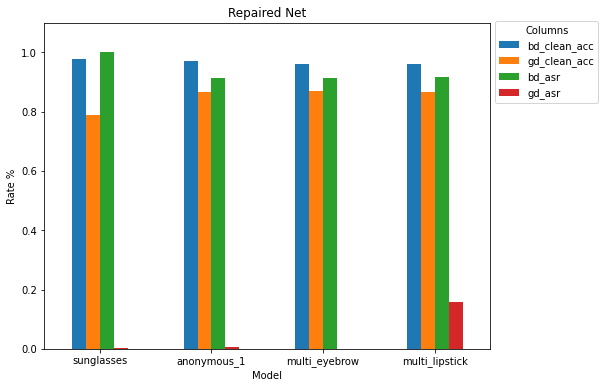

In [39]:

df = pd.DataFrame(data={'bd_clean_acc': bd_clean_accuracy_list, 'gd_clean_acc': gd_clean_accuracy_list, 'bd_asr': bd_asr, 'gd_asr': gd_asr}, index=['sunglasses','anonymous_1','multi_eyebrow','multi_lipstick'])

ax = df.plot(kind='bar', rot=0, xlabel='Model', ylabel='Rate %', title='Repaired Net', figsize=(8, 6))

ax.margins(y=0.1)

ax.legend(title='Columns', bbox_to_anchor=(1, 1.02), loc='upper left')

# Save Model

In [40]:
def Save_repaired_model(G,name):
  for i, g in enumerate(G):
    gi = name[i]
    g.save("/content/RepairedNet/{gi}.h5".format(gi=gi))
    g.save_weights("/content/RepairedNet/{gi}_weights.h5".format(gi=gi))



In [41]:
repaired_model_names = ['sunglasses_repaired_net','anonymous_1_repaired_net',
               'multi_trigger_multi_target_repaired_net_on_eyebrows',
               'multi_trigger_multi_target_repaired_net_on_lipstick']

Save_repaired_model(pruned_models,repaired_model_names)

/usr/local/lib/python3.7/dist-packages/keras/layers/wrappers.py:64: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  config = {'layer': generic_utils.serialize_keras_object(self.layer)}


# output class N+1 if the input is backdoored
it seems that even though we successfully decrease the asr, but we don’t achieve the requirement that "output class N+1 if the input is backdoored". We have some trable outputting such model , but if required , users can fisrt get the pruning model and then use pruning model and bad model to get such model that can output class  N+1 if the input is backdoored, we add an example here.

In [45]:
def new_model_output(bad_model,repaired_modol,test_x,test_y):
  bad_pre_y = np.argmax(bad_model.predict(test_x), axis=1)

  good_pre_y = np.argmax(repaired_modol.predict(test_x), axis=1)

  output_y = []
  for j in range(len(good_pre_y)):
    if good_pre_y[j] == bad_pre_y[j]:
      output_y.append(good_pre_y[j])
    else:
      output_y.append(biggest_class_value+1)# output value N+1 of this image classification
  output_y = np.array(output_y)

  return output_y

In [54]:
#take anonymous_1 for example
print(new_model_output(B2,pruned_models[1],clean_test_x,clean_test_y))

[950 992 823 ... 770 304 872]
